In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns

from uncertainties import ufloat
from ctypes import c_double

import ROOT
ROOT.EnableImplicitMT()    # Tells ROOT to go parallel

Welcome to JupyROOT 6.28/00


In [ ]:
import os

unique_dir = "vtx_PART_478best_valloss_epoch"

# ------------------------------------------------
sig_tag  = 'stop_M600_585_ct20_2018'



histname = "MET_pt_corr_vs_Max_ML_score_clone2"
# histname = "MET_pt_corr_vs_SP0_Max_ML_score"
tdir     = "all_evt"




bkg_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/bkg"
sig_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/" + unique_dir + "/sig"



sig_file = ROOT.TFile(os.path.join(sig_dir, f"{sig_tag}_hist.root"))
sig_dir  = getattr(sig_file, tdir)
sig_hist = getattr(sig_dir, histname).Clone()


bkg_file = ROOT.TFile(os.path.join(bkg_dir, f"all_2018_hist.root"))
bkg_dir  = getattr(bkg_file, tdir)
bkg_hist = getattr(bkg_dir, histname).Clone()

In [276]:
x_binwidth = sig_hist.GetXaxis().GetBinWidth(1)
y_binwidth = sig_hist.GetYaxis().GetBinWidth(1)

In [277]:
xax = sig_hist.GetXaxis()
yax = sig_hist.GetYaxis()

x_min = xax.GetBinLowEdge(1)
x_max = xax.GetBinUpEdge(xax.GetLast())

y_min = yax.GetBinLowEdge(1)
y_max = yax.GetBinUpEdge(yax.GetLast())

print(x_min, x_max, x_binwidth)
print(y_min, y_max, y_binwidth)

0.0 1000.0 50.0
0.95 1.0 5.000000000000004e-05


In [278]:
MET_boundaryList     = np.arange(200 + x_binwidth, x_max + x_binwidth, x_binwidth)
MLScore_boundaryList = np.arange(y_min,            y_max + y_binwidth, y_binwidth)

In [279]:
MET_boundaryList

array([ 250.,  300.,  350.,  400.,  450.,  500.,  550.,  600.,  650.,
        700.,  750.,  800.,  850.,  900.,  950., 1000.])

In [280]:
def sig(s,b,b_err):
  eps = 5e-1
  b     = max(b,     eps)
  b_err = max(b_err, eps)
  val = (2*((s+b)*np.log(((s+b)*(b+b_err*b_err))/(b*b+(s+b)*b_err*b_err)) -
        (b*b/(b_err*b_err))*np.log(1+(b_err*b_err*s)/(b*(b+b_err*b_err)))))
  return np.sqrt(max(0, val))

In [281]:
significances_dir = '/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/'+ unique_dir + '/significances'
os.makedirs(significances_dir, exist_ok=True)

In [282]:
y_binwidth

5.000000000000004e-05

In [283]:
significances_dir

'/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/vtx_PART_478best_valloss_epoch/significances'

In [ ]:
min_MLScore = 0.50

MET_step = MET_boundaryList[1] - MET_boundaryList[0]
MLScore_step = MLScore_boundaryList[1] - MLScore_boundaryList[0]

print(MET_boundaryList)
print(MLScore_boundaryList)

sigTable = pd.DataFrame(columns=np.arange(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgTable = pd.DataFrame(columns=np.arange(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgpredTable = pd.DataFrame(columns=np.arange(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgUncTable = pd.DataFrame(columns=np.arange(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgpredUncTable = pd.DataFrame(columns=np.arange(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

signifTable = pd.DataFrame(columns=np.arange(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

signifpredTable = pd.DataFrame(columns=np.arange(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

store = pd.HDFStore(os.path.join(significances_dir, 'dataframes_ML.h5'))


    
for MET_boundary in MET_boundaryList:
    for MLScore_boundary in MLScore_boundaryList:
        
        hist = bkg_hist
        
        allBkg_SPRA = 0
        allBkg_SPRB = 0
        allBkg_SPRC = 0
        allBkg_SPRD = 0

        MET_lo = -1
        MET_up = hist.GetNbinsX()+1
        MET_bound = hist.GetXaxis().FindBin(MET_boundary)

        MLScore_lo = hist.GetYaxis().FindBin(min_MLScore)
        MLScore_up = hist.GetNbinsY()+1
        MLScore_bound = hist.GetYaxis().FindBin(MLScore_boundary)

        x = c_double(0.0)
        SPRA = ufloat(hist.IntegralAndError(MET_bound, MET_up, MLScore_bound, MLScore_up,       x), x.value)
        SPRB = ufloat(hist.IntegralAndError(MET_bound, MET_up, MLScore_lo, MLScore_bound-1,     x), x.value)
        SPRC = ufloat(hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_bound, MLScore_up,     x), x.value)
        SPRD = ufloat(hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_lo, MLScore_bound-1,   x), x.value)

        allBkg_SPRA = SPRA
        allBkg_SPRB = SPRB
        allBkg_SPRC = SPRC
        allBkg_SPRD = SPRD

        # print((allBkg_SPRA + allBkg_SPRB + allBkg_SPRC + allBkg_SPRD).n)
        # print(allBkg_SPRA,allBkg_SPRB,allBkg_SPRC,allBkg_SPRD)

        bkgEventYield = allBkg_SPRA
        num = allBkg_SPRB
        denom = allBkg_SPRD * allBkg_SPRC
        bkgEventYield_pred = num / denom if denom != 0 else ufloat(0, 0)
 

        ### SIGNAL PART
        MET_lo = -1
        MET_up = sig_hist.GetNbinsX()+1
        MET_bound = sig_hist.GetXaxis().FindBin(MET_boundary)

        MLScore_lo = sig_hist.GetYaxis().FindBin(min_MLScore)
        MLScore_up = sig_hist.GetNbinsY()+1
        MLScore_bound = sig_hist.GetYaxis().FindBin(MLScore_boundary)

        x = c_double(0.0)
        SPRA = ufloat(sig_hist.IntegralAndError(MET_bound, MET_up, MLScore_bound, MLScore_up,     x), x.value) * (6.83 / 205)
        SPRB = ufloat(sig_hist.IntegralAndError(MET_bound, MET_up, MLScore_lo, MLScore_bound-1,   x), x.value) * (6.83 / 205)
        SPRC = ufloat(sig_hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_bound, MLScore_up,   x), x.value) * (6.83 / 205)
        SPRD = ufloat(sig_hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_lo, MLScore_bound-1, x), x.value) * (6.83 / 205)

        sigEventYield = SPRA

        bkg_yield_fixed = max(0, bkgEventYield.n)

        sigTable.loc[MLScore_boundary, MET_boundary]        = sigEventYield.n
        bkgTable.loc[MLScore_boundary, MET_boundary]        = bkg_yield_fixed
        bkgpredTable.loc[MLScore_boundary, MET_boundary]    = bkgEventYield_pred.n

        bkgUncTable.loc[MLScore_boundary, MET_boundary]     = bkgEventYield.s
        bkgpredUncTable.loc[MLScore_boundary, MET_boundary] = bkgEventYield_pred.s

        # if MLScore_boundary==20 and MET_boundary==650:
        #     print(bkgEventYield.s)
        # signifTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield.n, bkgEventYield.s), 3)
        # signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield_pred.n, bkgEventYield_pred.s), 3)
        # signifTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield.n, 1e-50), 3)
        # signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield_pred.n, 1e-50), 3)

        signifTable.loc[MLScore_boundary, MET_boundary]     = sig(sigEventYield.n, bkg_yield_fixed, (0.20 * bkg_yield_fixed))
        signifpredTable.loc[MLScore_boundary, MET_boundary] = sig(sigEventYield.n, bkgEventYield_pred.n, (0.20 * bkg_yield_fixed))
        # signifTable.loc[MLScore_boundary, MET_boundary] = round(sigEventYield.n / np.sqrt(bkgEventYield.n), 3)
        # signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sigEventYield.n / np.sqrt(bkgEventYield_pred.n), 3)

store[sig_tag + '_sigTable']        = sigTable             # save it
store[sig_tag + '_bkgTable']        = bkgTable             # save it
store[sig_tag + '_bkgpredTable']    = bkgpredTable         # save it
store[sig_tag + '_signifTable']     = signifTable          # save it
store[sig_tag + '_signifpredTable'] = signifpredTable      # save it
store[sig_tag + '_bkgUncTable']     = bkgUncTable          # save it
store[sig_tag + '_bkgpredUncTable'] = bkgpredUncTable      # save it
# store[sig_tag + '_closureUncTable'] = closureUncTable      # save it

# signifTable

[ 250.  300.  350.  400.  450.  500.  550.  600.  650.  700.  750.  800.
  850.  900.  950. 1000.]
[0.95    0.95005 0.9501  ... 0.99995 1.      1.00005]


In [285]:
store.keys()

['/stop_M600_585_ct20_2018_bkgTable',
 '/stop_M600_585_ct20_2018_bkgUncTable',
 '/stop_M600_585_ct20_2018_bkgpredTable',
 '/stop_M600_585_ct20_2018_bkgpredUncTable',
 '/stop_M600_585_ct20_2018_sigTable',
 '/stop_M600_585_ct20_2018_signifTable',
 '/stop_M600_585_ct20_2018_signifpredTable',
 '/stop_M600_588_ct200_2018_bkgTable',
 '/stop_M600_588_ct200_2018_bkgUncTable',
 '/stop_M600_588_ct200_2018_bkgpredTable',
 '/stop_M600_588_ct200_2018_bkgpredUncTable',
 '/stop_M600_588_ct200_2018_sigTable',
 '/stop_M600_588_ct200_2018_signifTable',
 '/stop_M600_588_ct200_2018_signifpredTable']

In [286]:
# store = pd.HDFStore(os.path.join(significances_dir, 'dataframes.h5'), 'r')

In [287]:
# c1 = ROOT.TCanvas()
# tfile = ROOT.TFile(os.path.join(dir, "stop_M600_580_ct2_2018_hist.root"))
# thist = tfile.SP_SDVSecVtx_all.SDVSecVtx_mass.Clone()
# 
# # thist.GetXaxis().SetRangeUser(100, 600) 
# # thist.GetYaxis().SetRangeUser(100, 600) 
# thist.Draw("HIST")
# c1.Draw()




# print(thist.GetEntries())
# for i in tfile.GetListOfKeys():
#     print(i)

In [288]:
# store.close()
# store.keys()

In [289]:
# tag= sig_tag
# 
# s = sns.heatmap(store[tag + '_signifpredTable'])
# s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Predicted Discovery Significances\n'+tag);
# s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
# s.invert_yaxis();

In [290]:
import matplotlib.pyplot as plt

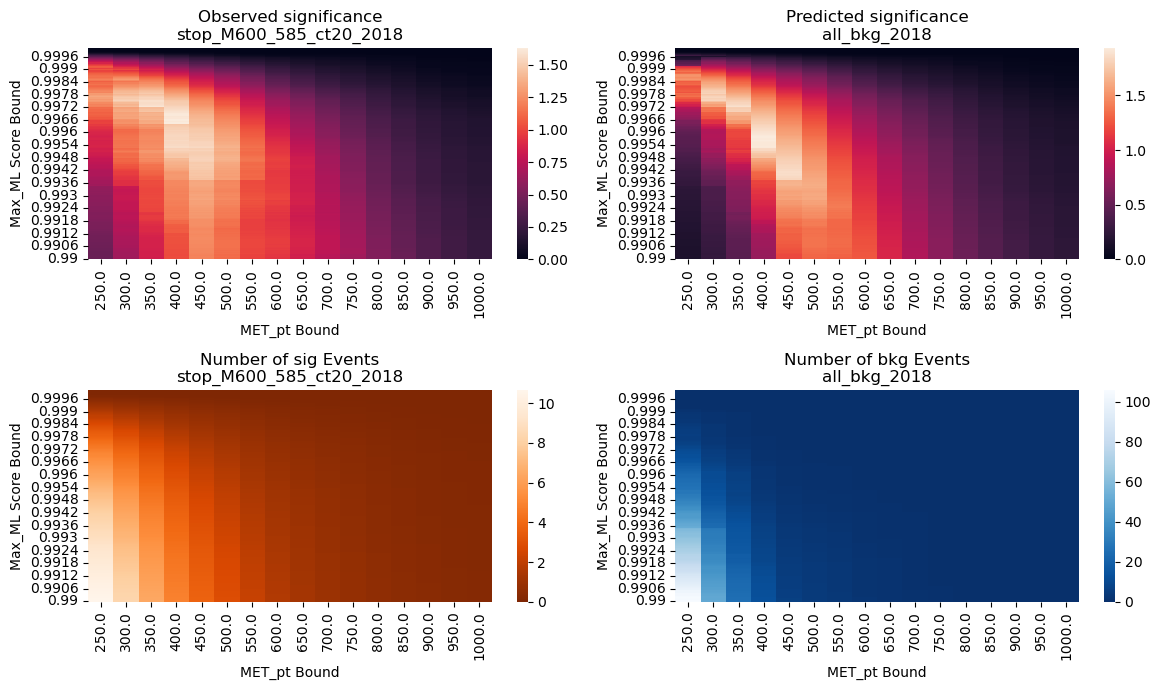

In [291]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
tag=sig_tag

ylabel = 'Max_ML Score Bound'
xlabel = 'MET_pt Bound'

plot_lowerBound = 0.99 # y_min

# Observed significance plot
sns.heatmap(store[tag + '_signifTable'][plot_lowerBound:], ax=axs[0,0])
axs[0,0].set(xlabel=xlabel, ylabel=ylabel, title='Observed significance\n' + tag)
axs[0,0].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[0,0].get_yticklabels())])
axs[0,0].invert_yaxis()

# Predicted significance plot
sns.heatmap(store[tag + '_signifpredTable'][plot_lowerBound:], ax=axs[0,1])
axs[0,1].set(xlabel=xlabel, ylabel=ylabel, title='Predicted significance\n' + 'all_bkg_2018')
axs[0,1].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[0,1].get_yticklabels())])
axs[0,1].invert_yaxis()

# Signal plot
sns.heatmap(store[tag + '_sigTable'][plot_lowerBound:], cmap='Oranges_r', ax=axs[1,0])
axs[1,0].set(xlabel=xlabel, ylabel=ylabel, title='Number of sig Events\n' + tag)
axs[1,0].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[1,0].get_yticklabels())])
axs[1,0].invert_yaxis()

# Background plot
sns.heatmap(store[tag + '_bkgTable'][plot_lowerBound:], cmap='Blues_r', ax=axs[1,1])
axs[1,1].set(xlabel=xlabel, ylabel=ylabel, title='Number of bkg Events\n' + 'all_bkg_2018')
axs[1,1].set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), axs[1,1].get_yticklabels())])
axs[1,1].invert_yaxis()

fig.tight_layout()
fig.show()


In [240]:
store[tag + '_signifTable'].loc[0.9994:0.9997]

,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0
0.99945,0.056925,0.045509,0.034733,0.026243,0.022047,0.015280,0.010402,0.008660,0.006098,0.003535,0.002604,0.001725,0.000868,0.0,0.0,0.0
0.99950,0.048842,0.039715,0.029719,0.022054,0.017845,0.013615,0.009540,0.007797,0.005234,0.002668,0.001737,0.000857,0.000000,0.0,0.0,0.0
0.99955,0.042003,0.034586,0.025402,0.018558,0.014337,0.011796,0.008679,0.006935,0.005234,0.002668,0.001737,0.000857,0.000000,0.0,0.0,0.0
0.99960,0.031772,0.027751,0.020283,0.014239,0.010004,0.008299,0.006901,0.005155,0.004304,0.001737,0.001737,0.000857,0.000000,0.0,0.0,0.0
0.99965,0.022426,0.020007,0.013279,0.011676,0.008305,0.006598,0.005198,0.003449,0.003449,0.000880,0.000880,0.000000,0.000000,0.0,0.0,0.0
0.99970,0.014732,0.012299,0.008996,0.007387,0.004819,0.004819,0.003417,0.002587,0.002587,0.000880,0.000880,0.000000,0.000000,0.0,0.0,0.0


In [164]:
store[tag + '_sigTable'].loc[0.9994:0.9997]

,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0
0.99945,23.946058,19.053114,14.395605,10.445347,8.087420,5.989061,4.536837,3.396007,2.587429,2.075404,1.738503,1.091881,0.963225,0.503035,0.378923,0.318345
0.99950,20.604935,16.418630,12.328121,8.903281,6.608703,4.898420,3.707409,2.823606,2.263326,1.815348,1.478447,0.966872,0.902647,0.442457,0.378923,0.318345
0.99955,17.413683,13.925790,10.485480,8.010298,5.973558,4.327495,3.193577,2.436364,1.931776,1.613273,1.415733,0.904158,0.839934,0.442457,0.378923,0.318345
0.99960,14.527244,11.544562,8.695771,6.674527,5.017514,3.698823,2.691843,2.057102,1.677501,1.358997,1.225470,0.778219,0.713995,0.316518,0.252984,0.192407
0.99965,11.420956,9.065387,6.651969,5.135635,3.541288,2.597172,1.849958,1.347626,1.091242,0.901360,0.838752,0.574731,0.510507,0.189816,0.189816,0.129238
0.99970,8.992634,7.062642,5.041587,3.922212,2.516304,1.691761,1.071131,0.827137,0.699409,0.699409,0.636800,0.508344,0.444119,0.189816,0.189816,0.129238


In [165]:
store[tag + '_bkgTable'].loc[0.9994:0.9997]

,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,950.0,1000.0
0.99945,0.269740,0.040565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.99950,0.269740,0.040565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.99955,0.269740,0.040565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.99960,0.269740,0.040565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.99965,0.040565,0.040565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.99970,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [398]:
sig(146.269714, 0, 0)

26.27108720622077

In [38]:
store[tag + '_bkgpredTable'].loc[3.5:4.0]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000


In [44]:
store[tag + '_sigTable'].loc[0.998:0.999]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.99800,54.185450,42.968129,34.040533,20.551403,16.602443,13.092986,10.338293,6.438901,5.060230,3.852476,3.252266,2.172088,1.542093,1.245247,0.953732,0.664495
0.99801,54.185450,42.968129,34.040533,20.551403,16.602443,13.092986,10.338293,6.438901,5.060230,3.852476,3.252266,2.172088,1.542093,1.245247,0.953732,0.664495
0.99802,54.034026,42.838539,33.955377,20.506405,16.557445,13.047988,10.293296,6.416125,5.037453,3.829699,3.229490,2.172088,1.542093,1.245247,0.953732,0.664495
0.99803,53.865170,42.669684,33.848824,20.420487,16.493917,12.984460,10.251989,6.393990,5.015319,3.807565,3.229490,2.172088,1.542093,1.245247,0.953732,0.664495
0.99804,53.656674,42.506115,33.732194,20.373436,16.446866,12.937409,10.204938,6.393990,5.015319,3.807565,3.229490,2.172088,1.542093,1.245247,0.953732,0.664495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.99896,31.936038,25.724969,20.561113,12.678209,10.245328,8.326746,6.448214,3.915476,3.111867,2.326815,2.017219,1.434370,0.984752,0.800941,0.578745,0.397594
0.99897,31.558391,25.435560,20.337040,12.543582,10.153383,8.234802,6.400319,3.867581,3.063972,2.301574,1.991977,1.434370,0.984752,0.800941,0.578745,0.397594
0.99898,31.201339,25.166185,20.223644,12.498439,10.108240,8.189658,6.377671,3.867581,3.063972,2.301574,1.991977,1.434370,0.984752,0.800941,0.578745,0.397594
0.99899,30.938675,25.012470,20.069929,12.344724,9.999557,8.080975,6.311758,3.824169,3.020560,2.258162,1.948566,1.390959,0.941340,0.757530,0.535333,0.354182


In [40]:
store[tag + '_signifTable'].loc[3.5:4.0]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000


In [41]:
store[tag + '_signifpredTable'].loc[3.5:4.0]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000


In [43]:
store[tag + '_signifTable'].loc[0.998:0.999]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.99800,2.682065,3.069106,3.571967,4.658047,4.691721,4.739924,4.425309,3.170567,3.267250,2.746729,2.577727,2.096684,3.384909,2.959529,2.497840,1.977102
0.99801,2.682065,3.069106,3.571967,4.658047,4.691721,4.739924,4.425309,3.170567,3.267250,2.746729,2.577727,2.096684,3.384909,2.959529,2.497840,1.977102
0.99802,2.678625,3.066334,3.573493,4.679781,4.722740,4.788674,4.485627,3.201801,3.295537,2.772640,2.608005,2.096684,3.384909,2.959529,2.497840,1.977102
0.99803,2.685972,3.073930,3.576229,4.705014,4.722782,4.771146,4.472121,3.193105,3.284518,2.760219,2.608005,2.096684,3.384909,2.959529,2.497840,1.977102
0.99804,2.680471,3.065755,3.569190,4.696626,4.712468,4.758143,4.456711,3.193105,3.284518,2.760219,2.608005,2.096684,3.384909,2.959529,2.497840,1.977102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.99896,4.053714,4.684326,6.358477,6.485048,6.483966,NaN,NaN,4.711707,4.501493,3.750085,3.418356,3.271453,2.580843,2.261143,1.830815,1.427037
0.99897,4.040088,4.661842,6.350254,6.551371,6.638597,NaN,NaN,5.134163,4.457331,3.723754,3.390412,3.271453,2.580843,2.261143,1.830815,1.427037
0.99898,4.011714,4.631574,6.350679,6.535263,6.619014,NaN,NaN,5.134163,4.457331,3.723754,3.390412,3.271453,2.580843,2.261143,1.830815,1.427037
0.99899,4.043798,4.616564,6.337036,6.535701,6.571716,NaN,NaN,5.097851,4.417049,3.678186,3.342010,3.209207,2.507741,2.181350,1.739323,1.320003


In [45]:
tmp_df = store[tag + '_signifTable'].to_numpy()
tmp_df[np.isnan(tmp_df)] = 0.
np.where(tmp_df == tmp_df.max())
store[tag + '_signifTable'].iloc[50:150:10,5:6]

,500
0.999695,26.635726
0.999698,26.363346
0.999701,26.771910
0.999704,26.605957
0.999707,26.367625
0.999710,26.127781
0.999713,27.035750
0.999716,27.056317
0.999719,26.677856
0.999722,23.656767


In [43]:
store[tag + '_signifTable'].index[116]

0.9997147999999946

In [13]:
df = store[tag + '_signifpredTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

3.274

In [14]:
from matplotlib.colors import LogNorm, Normalize

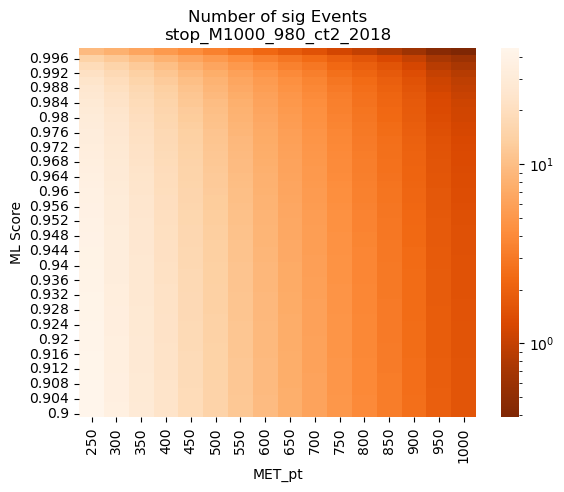

In [15]:
s = sns.heatmap(store[tag + '_sigTable'], norm=LogNorm(), cmap='Oranges_r')
s.set(xlabel='MET_pt', ylabel='ML Score', title='Number of sig Events\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

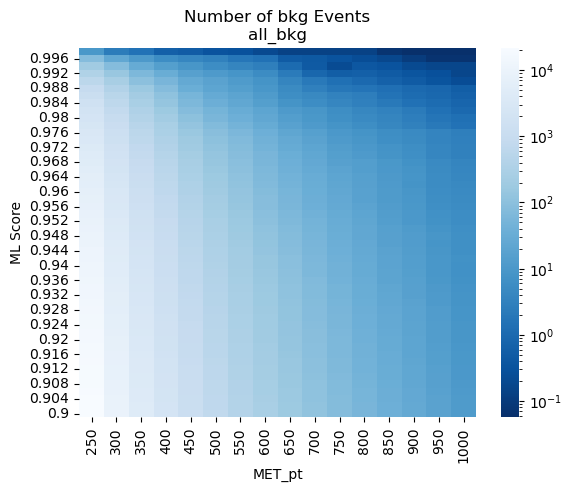

In [16]:
s = sns.heatmap(store[tag + '_bkgTable'], norm=LogNorm(), cmap='Blues_r')
s.set(xlabel='MET_pt', ylabel='ML Score', title='Number of bkg Events\n'+"all_bkg");
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

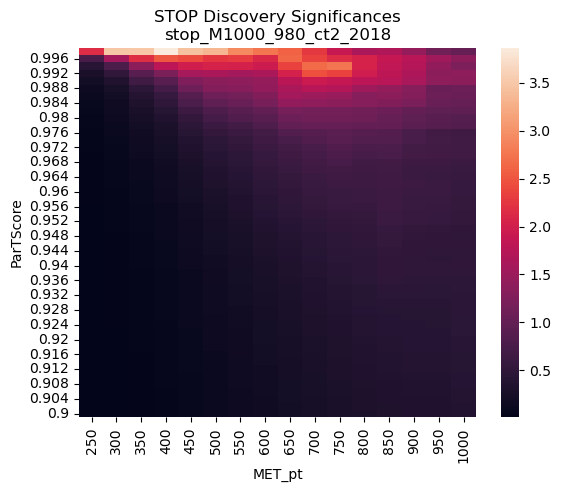

In [17]:
s = sns.heatmap(store[tag + '_signifTable'])
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [18]:
# store[tag + '_signifTable']

In [57]:
df = store[tag + '_signifTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

3.867

In [64]:
df[~df.isna()]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.900,0.010,0.020,0.033,0.052,0.076,0.107,0.135,0.165,0.200,0.237,0.268,0.293,0.317,0.329,0.335,0.365
0.902,0.010,0.020,0.034,0.053,0.078,0.109,0.139,0.170,0.205,0.243,0.273,0.298,0.320,0.332,0.338,0.369
0.904,0.011,0.021,0.035,0.054,0.079,0.110,0.141,0.173,0.209,0.247,0.278,0.306,0.327,0.339,0.341,0.372
0.906,0.011,0.021,0.035,0.055,0.081,0.113,0.145,0.178,0.216,0.253,0.283,0.310,0.332,0.344,0.346,0.376
0.908,0.011,0.022,0.036,0.056,0.083,0.115,0.147,0.180,0.217,0.255,0.288,0.316,0.339,0.354,0.355,0.391
0.910,0.011,0.022,0.037,0.057,0.084,0.118,0.151,0.185,0.224,0.263,0.297,0.328,0.351,0.362,0.362,0.401
0.912,0.012,0.023,0.038,0.059,0.087,0.121,0.154,0.190,0.229,0.268,0.303,0.339,0.359,0.372,0.372,0.403
0.914,0.012,0.023,0.039,0.060,0.089,0.125,0.160,0.195,0.235,0.274,0.308,0.344,0.363,0.376,0.378,0.412
0.916,0.012,0.024,0.040,0.062,0.091,0.128,0.164,0.200,0.240,0.280,0.313,0.351,0.368,0.382,0.383,0.415
0.918,0.012,0.024,0.041,0.063,0.094,0.131,0.167,0.204,0.245,0.283,0.317,0.354,0.375,0.388,0.390,0.426


In [ ]:
store[tag + '_sigTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,21.394,17.480,14.179,11.560,9.195,7.462,5.950,4.836,3.965,3.302,2.615,2.161,1.771,1.401,1.006,0.847
0.994,18.474,15.111,12.243,9.982,7.924,6.439,5.151,4.205,3.433,2.878,2.297,1.927,1.561,1.210,0.872,0.732
0.996,14.573,12.077,9.858,8.079,6.414,5.227,4.210,3.426,2.834,2.363,1.913,1.596,1.282,1.006,0.718,0.613
0.998,9.398,7.875,6.458,5.305,4.204,3.403,2.763,2.234,1.824,1.508,1.196,0.983,0.807,0.622,0.442,0.387


In [60]:
store[tag + '_bkgTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,371.181,151.202,63.422,32.810,16.139,11.286,8.420,5.380,2.258,0.887,0.560,0.611,0.486,0.355,0.272,0.170
0.994,196.533,81.155,29.982,14.913,8.664,5.664,3.828,2.863,1.095,0.465,0.218,0.396,0.327,0.208,0.166,0.166
0.996,80.915,24.383,10.585,5.563,3.936,3.116,1.890,1.483,0.477,0.430,0.324,0.239,0.173,0.109,0.069,0.069
0.998,9.852,2.381,1.500,0.632,0.519,0.316,0.291,0.193,0.135,0.135,0.135,0.135,0.070,0.057,0.057,0.057


In [61]:
store[tag + '_bkgpredTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,340.011,154.413,75.136,39.066,21.675,12.585,7.652,4.827,3.130,2.078,1.400,0.966,0.675,0.473,0.337,0.244
0.994,182.654,82.354,40.476,20.979,11.571,6.725,4.091,2.577,1.671,1.109,0.747,0.516,0.360,0.253,0.180,0.130
0.996,59.031,30.717,14.607,7.552,4.149,2.408,1.470,0.926,0.602,0.399,0.269,0.186,0.130,0.091,0.065,0.047
0.998,12.324,5.490,2.464,1.275,0.696,0.405,0.246,0.155,0.100,0.067,0.045,0.031,0.022,0.015,0.011,0.008


In [49]:
store[tag + '_bkgpredTable'][0.992:] / store[tag + '_bkgTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,0.916024,1.021236,1.184711,1.190678,1.343003,1.115077,0.908712,0.897122,1.386066,2.343597,2.501320,1.580172,1.387696,1.334707,1.241052,1.432149
0.994,0.929380,1.014775,1.349989,1.406752,1.335572,1.187311,1.068767,0.900050,1.525728,2.387654,3.428721,1.303238,1.102658,1.215218,1.083086,0.783314
0.996,0.729542,1.259798,1.380027,1.357497,1.054126,0.772710,0.777780,0.624507,1.262470,0.929047,0.829071,0.778481,0.748910,0.831723,0.934718,0.676041
0.998,1.250941,2.305907,1.642860,2.016810,1.342223,1.280819,0.845022,0.802531,0.741716,0.491648,0.331063,0.228556,0.309691,0.268323,0.191122,0.138231


In [50]:
store[tag + '_bkgpredUncTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,22.608757,8.690250,3.987687,2.009431,1.096163,0.633689,0.384313,0.241802,0.156367,0.103796,0.069995,0.048418,0.033888,0.023860,0.017078,0.012424
0.994,18.099348,6.913669,3.205182,1.613522,0.879060,0.508136,0.308051,0.193725,0.125235,0.083069,0.055975,0.038677,0.027030,0.018992,0.013558,0.009831
0.996,8.285269,3.921680,1.865693,0.938813,0.511556,0.295545,0.179219,0.112669,0.072817,0.048276,0.032516,0.022456,0.015682,0.011008,0.007847,0.005681
0.998,5.631895,1.820603,0.793396,0.398047,0.217248,0.125449,0.076028,0.047794,0.030874,0.020466,0.013782,0.009515,0.006642,0.004660,0.003319,0.002401


In [51]:
store[tag + '_bkgUncTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,27.732482,15.265945,6.174329,4.231936,2.979552,2.282705,1.873984,1.450633,0.838655,0.479560,0.466813,0.165760,0.145832,0.128079,0.114829,0.089867
0.994,22.314324,12.929929,4.370446,2.841417,2.209911,1.569743,1.410760,1.211864,0.689063,0.462504,0.451730,0.136606,0.119892,0.098375,0.089833,0.089833
0.996,16.173062,8.613418,2.438424,1.577224,1.099651,0.869235,0.559525,0.546996,0.136922,0.132440,0.117477,0.104563,0.081571,0.070493,0.058004,0.058004
0.998,2.104737,1.137729,0.829251,0.705665,0.154350,0.120536,0.119283,0.104902,0.087499,0.087499,0.087499,0.087499,0.058107,0.056571,0.056571,0.056571


In [59]:
store[tag + '_bkgUncTable'].loc[0.998:,1000]

0.998    0.056571
Name: 1000, dtype: float64

In [60]:
store[tag + '_bkgTable'].loc[0.998:,1000]

0.998    0.056571
Name: 1000, dtype: float64

In [54]:
store[tag + '_bkgpredUncTable'].loc[0.998:,1000]

0.998    0.002401
Name: 1000, dtype: float64

In [55]:
store[tag + '_bkgpredTable'].loc[0.998:,1000]

0.998    0.00782
Name: 1000, dtype: float64

In [56]:
(store[tag + '_bkgpredTable'].loc[0.998:,1000]/ store[tag + '_bkgpredUncTable'].loc[0.998:,1000])**2

0.998    10.605589
Name: 1000, dtype: float64

In [64]:
(0.00782 / 0.002401)**2

10.607894357498205

In [65]:
(0.056571 / 0.056571)**2

1.0

In [61]:
ufloat(0.00782, 0.002401) / ufloat(0.056571, 0.056571)

0.13823337045482667+/-0.14460224239263791

In [66]:
import ROOT

# --- 1. create one‑bin histograms with your Poisson counts ------------------
h_num = ROOT.TH1D("num","",1,0,1)   # numerator: n1
h_den = ROOT.TH1D("den","",1,0,1)   # denominator: n2
h_num.SetBinContent(1, 10)          # e.g. n1 = 10
h_den.SetBinContent(1, 1)          # e.g. n2 = 73   (change to your numbers)

# --- 2. build the ratio of Poisson means with 68.3 % (1 σ) Clopper‑Pearson --
g = ROOT.TGraphAsymmErrors()
g.Divide(h_num, h_den, "pois cp")   # add "v" for verbose output if you like

# --- 3. access the central value and asymmetric errors ----------------------
ratio      = g.GetY()[0]            # τ̂  = n1 / n2
err_low    = g.GetErrorYlow(0)      # downward error
err_high   = g.GetErrorYhigh(0)     # upward   error
print(f"τ = {ratio:.6f}  +{err_high:.6f}/-{err_low:.6f}")

# optional: draw the graph (as a single point)
# c = ROOT.TCanvas()
# g.SetMarkerStyle(20)
# g.Draw("AP")
# c.Update()


τ = 10.000000  +53.175748/-7.299097


Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: den (Potential memory leak).


In [ ]:
g.Divide(h_num, h_den, "pois fc")                   # Feldman‑Cousins 68 % CL
g.Divide(h_num, h_den, "pois b(0.5,0.5) shortest")  # Bayesian Jeffreys prior

In [69]:
from uncertainties import ufloat

def ratio_gauss(muA, sigA, muB, sigB):
    """
    Return R = A/B with its propagated 1‑sigma error,
    assuming A and B are independent Gaussians.
    """
    a = ufloat(muA, sigA)
    b = ufloat(muB, sigB)
    return a / b

# example -------------------------------------------------------------
ra = ratio_gauss(0.00782,   0.002401,
                 0.056571,  0.056571)
print(ra)        # ==> 0.138233±0.144602

0.14+/-0.14


In [63]:
from scipy import stats
import numpy as np

my_dict = {}
my_val = 0.7

mu1s_68 = []
mu2s_68 = []

mu1s_95 = []
mu2s_95 = []

trial1s = np.random.uniform(0, 300, 10000)
trial2s = np.random.uniform(0, 300, 10000)

for mu1, mu2 in zip(trial1s, trial2s):
    rvs1 = stats.poisson.rvs(mu1, size=1000)
    rvs2 = stats.poisson.rvs(mu2, size=1000)
    rvs_ratio = rvs1 / rvs2
    ci68 = np.percentile(rvs_ratio, [16, 84])
    ci95 = np.percentile(rvs_ratio, [2.5, 97.5])
    # if np.isnan(ci68[0]) or np.isnan(ci68[1]):
    #     continue
    if ci68[0] <= my_val <= ci68[1]:
        # print(f"my_val is inside the range of x: {x[0]:.2f} <= {my_val:.2f} <= {x[1]:.2f}")
        mu1s_68.append(mu1)
        mu2s_68.append(mu2)
    if ci95[0] <= my_val <= ci95[1]:
        # print(f"my_val is inside the range of x: {x[0]:.2f} <= {my_val:.2f} <= {x[1]:.2f}")
        mu1s_95.append(mu1)
        mu2s_95.append(mu2)
        
        # my_dict[f'{mu1:.2f}_{mu2:.2f}'] = x

/tmp/ipykernel_4077/3913191389.py:19: RuntimeWarning: divide by zero encountered in divide
  rvs_ratio = rvs1 / rvs2
/groups/hephy/cms/alikaan.gueven/conda/envs/coffea_torch2/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_4077/3913191389.py:19: RuntimeWarning: invalid value encountered in divide
  rvs_ratio = rvs1 / rvs2


In [56]:
rvs1 = stats.poisson.rvs(200, size=1000)
rvs2 = stats.poisson.rvs(300, size=1000)
rvs_ratio = rvs1 / rvs2
x = np.percentile(rvs_ratio, [16, 84])
x

array([0.60688449, 0.72831056])

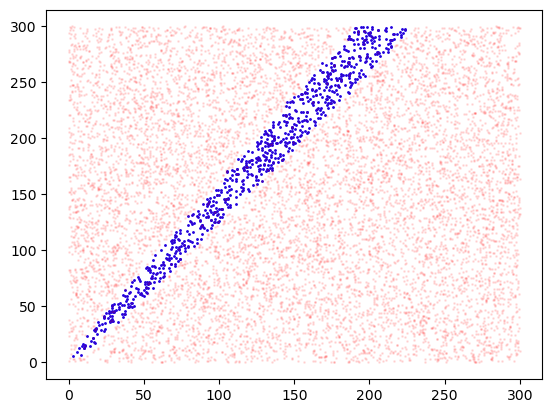

In [64]:
plt.plot(mu1s_68, mu2s_68, 'o', markersize=1, color="blue")
plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

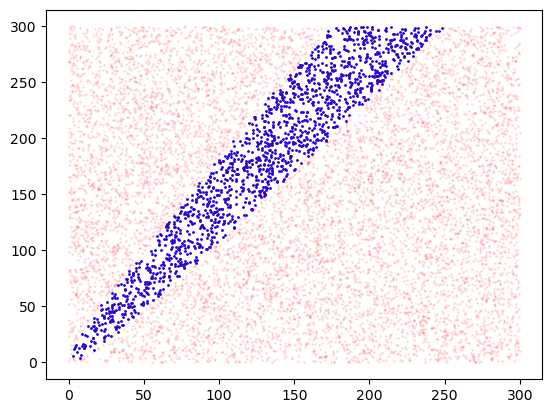

In [65]:
plt.plot(mu1s_95, mu2s_95, 'o', markersize=1, color="blue")
plt.plot(trial1s, trial2s, 'o', markersize=1, color="red", alpha=0.1)

In [ ]:
l = [0,2]
my_val = np.nan

if l[0] > my_val or l[-1] < my_val :
    print("my_val is outside the range of l")


my_val is outside the range of l


In [73]:
rvs1 = stats.poisson.rvs(20, size=1000)
rvs2 = stats.poisson.rvs(10, size=1000)
rvs_ratio = rvs1 / rvs2
x = np.percentile(rvs_ratio, [16, 50, 84])
x

array([1.41666667, 2.1       , 3.14285714])

In [30]:
store[tag + '_closureUncTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,0.092,0.118,0.131,0.165,0.257,0.232,0.207,0.246,0.519,1.273,2.090,0.436,0.422,0.487,0.528,0.759
0.994,0.140,0.183,0.224,0.289,0.355,0.341,0.402,0.387,0.967,2.383,7.109,0.460,0.413,0.582,0.591,0.428
0.996,0.178,0.473,0.364,0.420,0.322,0.236,0.249,0.243,0.393,0.308,0.317,0.354,0.364,0.545,0.790,0.571
0.998,0.631,1.341,1.051,2.338,0.579,0.629,0.434,0.501,0.531,0.352,0.237,0.164,0.275,0.281,0.200,0.145


In [65]:
store[tag + '_signifTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,0.274,0.517,0.892,1.222,1.594,1.633,1.569,1.643,2.034,2.449,2.352,1.970,1.808,1.655,1.380,1.383
0.994,0.430,0.773,1.374,1.800,1.992,2.058,2.034,1.939,2.357,2.669,2.740,2.055,1.846,1.723,1.425,1.244
0.996,0.749,1.564,2.165,2.519,2.420,2.250,2.291,2.116,2.619,2.349,2.162,2.048,1.888,1.769,1.539,1.371
0.998,2.159,3.483,3.491,3.867,3.434,3.330,2.923,2.761,2.588,2.258,1.908,1.649,1.673,1.453,1.130,1.022


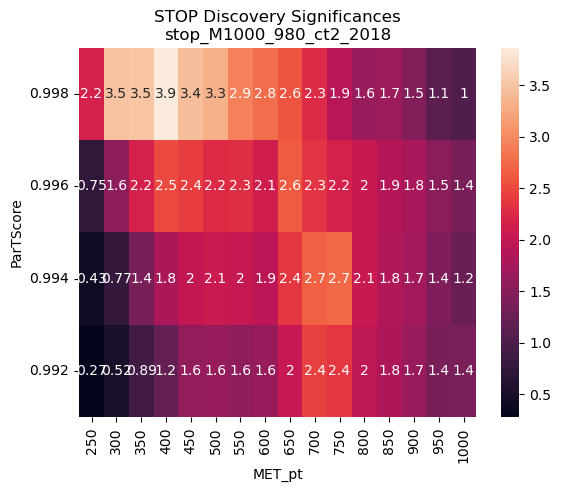

In [ ]:
s = sns.heatmap(store[tag + '_signifTable'][0.992:], annot=True)
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();
plt.

In [ ]:
# d.to_csv(sep = "|")
tableName = tag + '_bkgTable'
print(f"Printing {tableName} \n")
d = store[tableName]
s = d.to_markdown()
s = "| ParTScore/MET_pt" + s[6:]
print(s)

In [ ]:
for key in bkg_histDict.keys():
    print(key)

In [ ]:
c = ROOT.TCanvas("c1","myCanvas1",600,600)
h = bkg_histDict['zjetstonunuht2500_2018']
h.Draw("COLZ")
h.GetXaxis().SetRange(-1, 1000)
h.GetYaxis().SetRange(-1, 1000)
c.Draw()

In [ ]:
sig(15.903, 4.079, 0.4513)

In [ ]:
sig(5, 4.079, 0.4513)

In [ ]:
5 / 15.903

In [ ]:
store[tag + '_sigTable']

In [ ]:
tag = 'stop_1000_980_2'

s = sns.heatmap(store[tag + '_bkgTable'], cmap="Blues_r")
s.set(xlabel='MET_pt', ylabel='LxySig', title='STOP Events\n'+tag);
s.invert_yaxis();

In [ ]:
# d.to_csv(sep = "|")
tag = 'stop_1000_980_2'
d = store[tag + '_bkgTable']
s = d.to_markdown()
s = "| LxySig/MET_pt " + s[6:]

In [ ]:
print(f"{s}")

In [ ]:
# hist.GetYaxis().GetBinUpEdge(hist.GetYaxis().GetNbins())

In [ ]:
store['stop_1000_988_200_sigTable']

In [ ]:
store['stop_1000_988_200_bkgTable']

In [ ]:
store['stop_1000_988_200_signifTable']

In [ ]:
def sig(s,b,b_err):
  return np.sqrt(2*((s+b)*np.log(((s+b)*(b+b_err*b_err))/(b*b+(s+b)*b_err*b_err)) - 
                    (b*b/(b_err*b_err))*np.log(1+(b_err*b_err*s)/(b*(b+b_err*b_err)))))

In [ ]:
sig(0.2, 0.5, 1e-154)

In [ ]:
0.2 / np.sqrt(0.5)

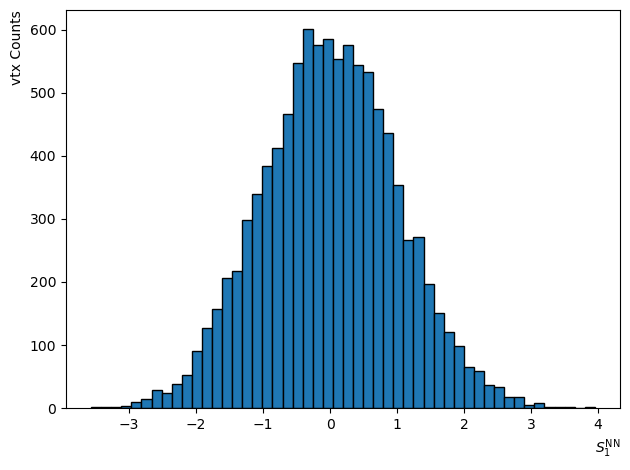

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# toy data
x = np.random.normal(loc=0, scale=1, size=10_000)

plt.figure()
plt.hist(x, bins=50, edgecolor='black')             # quick 1D histogram
plt.xlabel(r'$S_{1}^{\mathrm{NN}}$', loc='right')               # LaTeX-style axis label
plt.ylabel('vtx Counts',        loc='top')
plt.tight_layout()
plt.show()

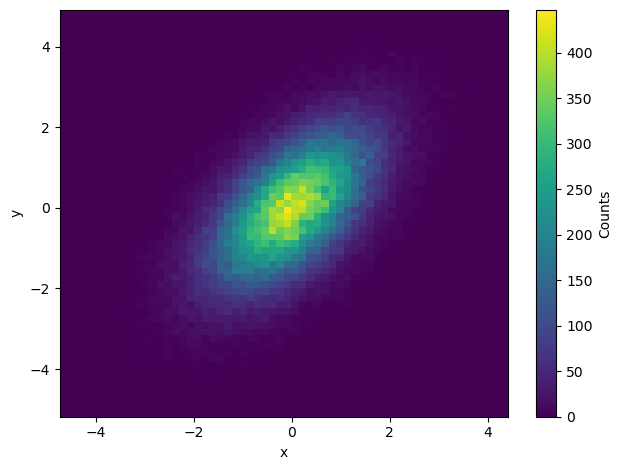

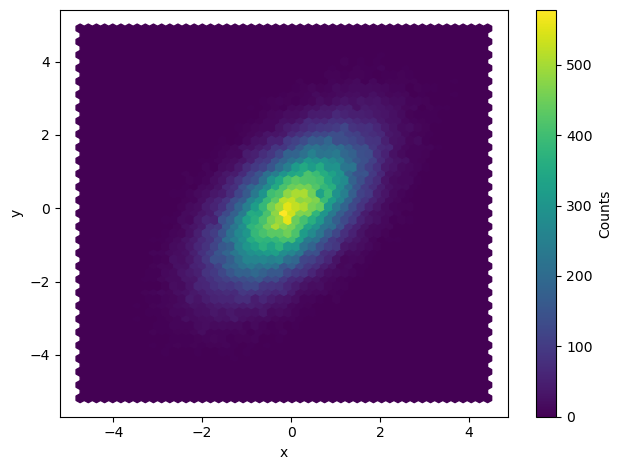

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist2d(x, y, bins=60, range=None):
    plt.figure()
    h = plt.hist2d(x, y, bins=bins, range=range)  # range=((xmin,xmax),(ymin,ymax))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(h[3], label='Counts')
    plt.tight_layout()
    plt.show()

def plot_hexbin(x, y, gridsize=60, extent=None):
    plt.figure()
    hb = plt.hexbin(x, y, gridsize=gridsize, extent=extent)  # extent=(xmin,xmax,ymin,ymax)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(hb, label='Counts')
    plt.tight_layout()
    plt.show()


x = np.random.normal(0, 1, 100_000)
y = 0.7 * x + np.random.normal(0, 1, 100_000)

plot_hist2d(x, y)            # rectangular bins
plot_hexbin(x, y, gridsize=50)  # hex bins


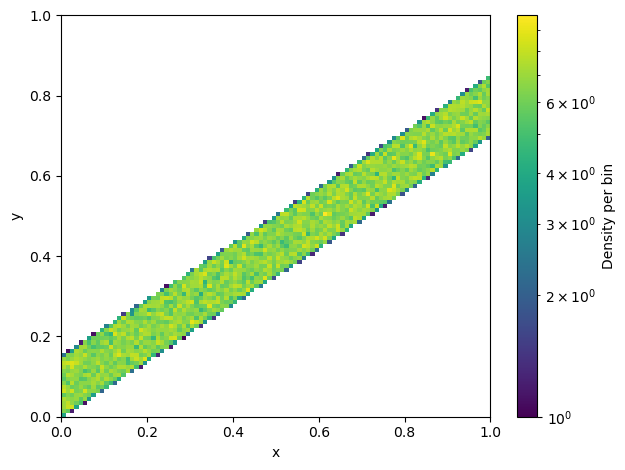

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, LogFormatter, NullLocator
import matplotlib.ticker as ticker

def hist2d_01_log(x, y, binwidth=0.02, cmin=1e-3, force_ticks=4):
    """
    2D histogram on [0,1]x[0,1] with log color scale and exactly `force_ticks` ticks.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # bins that include 1.0
    xbins = np.arange(0, 1 + binwidth, binwidth)
    ybins = np.arange(0, 1 + binwidth, binwidth)

    plt.figure()
    h = plt.hist2d(
        x, y,
        bins=[xbins, ybins],
        range=((0, 1), (0, 1)),
        density=True,
        cmin=cmin,                         # hide very-sparse bins
        norm=LogNorm()                     # temporary; will override vmin/vmax below
    )

    # Determine vmin/vmax from shown (nonzero) data
    H = h[0]
    positive = H[H > 0]
    if positive.size == 0:
        plt.colorbar(h[3], label='Density per bin')
        plt.xlabel('x'); plt.ylabel('y')
        plt.tight_layout(); plt.show()
        return

    vmin = max(cmin, positive.min())
    vmax = positive.max()

    # pass ticks & formatter when creating the colorbar
    plt.colorbar(
        h[3],
        label='Density per bin',
        format=LogFormatter(base=10)
    )
    h[3].set_norm(LogNorm(vmin=vmin, vmax=vmax))

    plt.xlabel('x'); plt.ylabel('y')
    plt.tight_layout()
    plt.show()


# Example:
x = np.random.rand(100_000)
y = 0.7*x + 0.15*np.random.rand(100_000)
hist2d_01_log(x, y, binwidth=0.01, cmin=1)
